In [114]:
if (!require(rgdal)) {
    install.packages("rgdal")
    library(rgdal)
}

if (!require(geojsonio)) {
    install.packages("geojsonio")
    library(geojsonio)
}

if (!require(dismo)) {
    install.packages("dismo")
    library(dismo)
}

if (!require(deldir)) {
    install.packages("deldir")
    library(deldir)
}

if (!require(sp)) {
    install.packages("sp")
    library(sp)
}

if (!require(gstat)) {
    install.packages("gstat")
    library(gstat)
}


if (!require("rspatial")) {
    devtools::install_github('rspatial/rspatial')
}

Loading required package: gstat

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'gstat'"
also installing the dependencies 'xts', 'intervals', 'zoo', 'spacetime', 'FNN'




package 'xts' successfully unpacked and MD5 sums checked
package 'intervals' successfully unpacked and MD5 sums checked
package 'zoo' successfully unpacked and MD5 sums checked
package 'spacetime' successfully unpacked and MD5 sums checked
package 'FNN' successfully unpacked and MD5 sums checked
package 'gstat' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Mazel\AppData\Local\Temp\RtmpKgZBTl\downloaded_packages


In [88]:
file = geojson_read("meeting-test/data_2020-03-02T22-00-00.geojson", TRUE)

coordinates.raw <- file$features$geometry$coordinates
coordinates.epsg4326 <- data.frame(matrix(unlist(coordinates.raw), nrow=length(coordinates.raw), byrow=T))

colnames(coordinates.epsg4326)[colnames(coordinates.epsg4326) == 'X1'] <- 'x'
colnames(coordinates.epsg4326)[colnames(coordinates.epsg4326) == 'X2'] <- 'y'

values <- file$features$properties$value

# https://epsg.io/3068
crs.external <- CRS("+init=epsg:4326")
crs.internal <- CRS("+init=epsg:3068")

In [89]:
coordinates(coordinates.epsg4326) <- c("x", "y")
proj4string(coordinates.epsg4326) <- crs.external

In [90]:
coordinates.epsg3068 <- spTransform(coordinates.epsg4326, crs.internal)

In [91]:
coordinates.epsg3068$value <- values

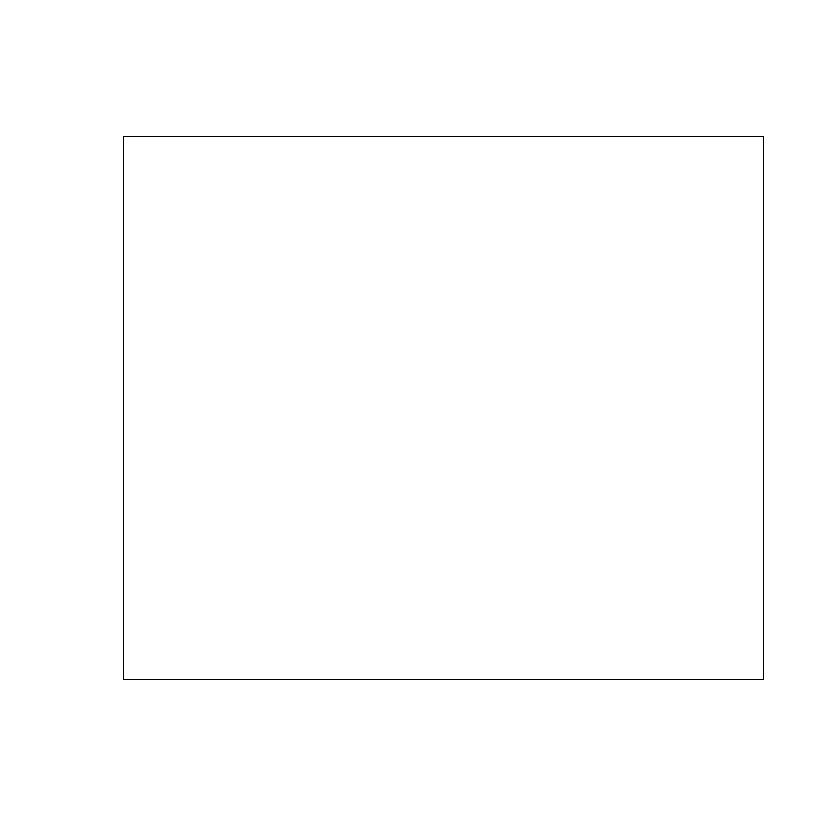

In [93]:
xmin <- min(coordinates.epsg3068$x)
ymin <- min(coordinates.epsg3068$y)
xmax <- max(coordinates.epsg3068$x)
ymax <- max(coordinates.epsg3068$y)

bbox <- as(raster::extent(xmin, xmax, ymin, ymax), "SpatialPolygons")
proj4string(bbox) <- crs.internal
# plot(bbox)

In [107]:
zones <- c(0,20,40,100,200,400)

In [64]:
RMSE <- function(observed, predicted) {
  sqrt(mean((predicted - observed)^2, na.rm=TRUE))
}

In [66]:
null <- RMSE(mean(coordinates.epsg3068$value), coordinates.epsg3068$value)
null

[1] 9.334609

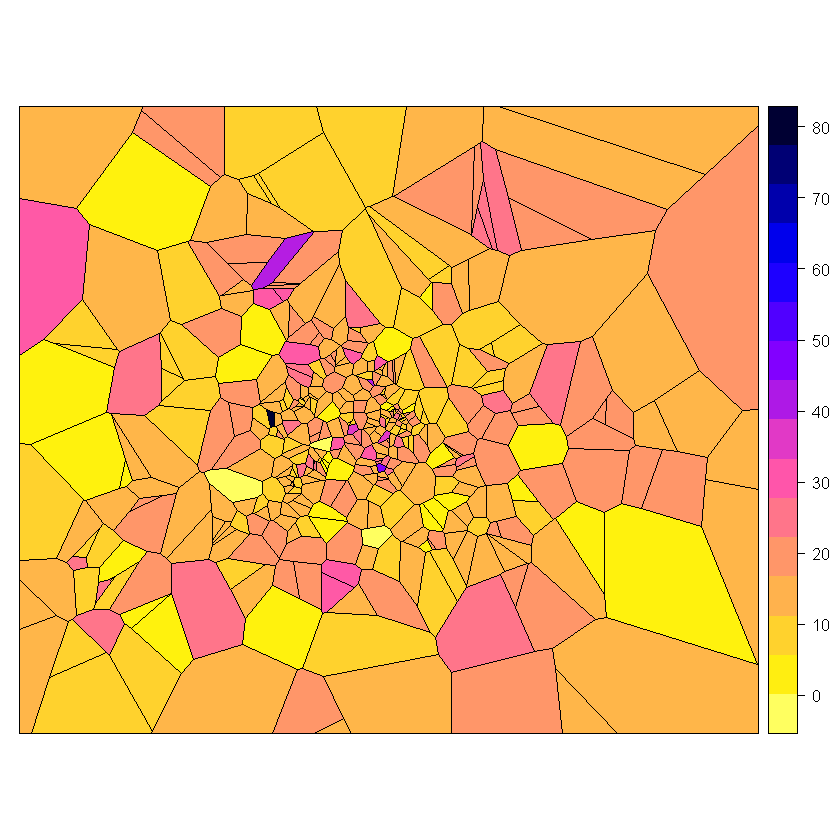

In [110]:
# Nearest Neighbor

v <- voronoi(coordinates.epsg3068)

# plot(v)

v <- intersect(v, bbox)
spplot(v, 'value', col.regions=rev(get_col_regions()))

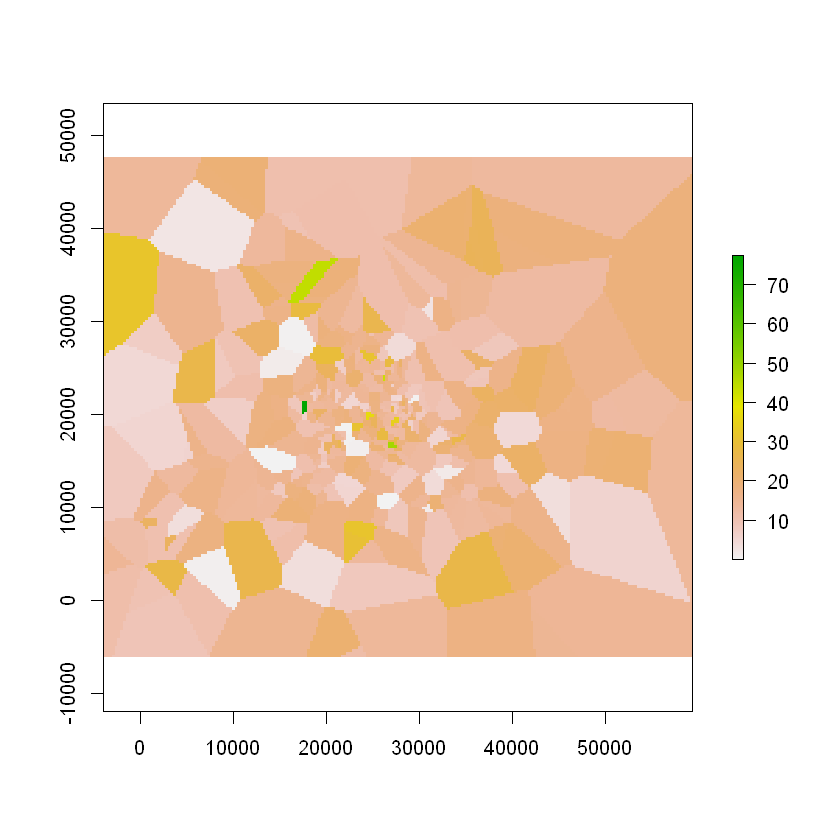

In [112]:
raster <- raster(bbox, res=300)
vr <- rasterize(v, raster, 'value')
plot(vr)